In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import Any, Literal, Optional, Union

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)
from settings import refresh_settings  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [4]:
from instructor import AsyncInstructor

from schemas import GeneralResponse, ModelEnum
from utilities.client_utils import get_client

In [5]:
local_client: AsyncInstructor = get_client(is_remote=False)
remote_client: AsyncInstructor = get_client(is_remote=True)

Using Ollama
Using Remote


In [6]:
messages = [
    {
        "role": "assistant",
        "content": "/no_think You're an expert AI assstance that replies to questions. "
        "Your responses are returned in a string format only. ",
    },
    {
        "role": "user",
        "content": "Tell me briefly something unique about SF. ",
    },
]

response: GeneralResponse = await local_client.chat.completions.create(
    messages=messages,
    response_model=GeneralResponse,
    model=ModelEnum.BASE_MODEL_LOCAL_2.value,
    max_tokens=700,
    max_retries=3,
    temperature=0.0,
    seed=0,
)
console.log(response.content)

[19:29:28] San Francisco is known for its iconic Golden Gate Bridge, vibrant cultural scene, and   ]8;id=289828;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_80474/2829152137.py\2829152137.py]8;;\:]8;id=959157;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_80474/2829152137.py#22\22]8;;\
           the famous Alcatraz Island, which was a federal prison and now a tourist attraction.                    

In [7]:
response: GeneralResponse = await remote_client.chat.completions.create(
    messages=messages,
    response_model=GeneralResponse,
    model=ModelEnum.BASE_REMOTE_MODEL_1_7B.value,
    max_tokens=700,
    max_retries=3,
    temperature=0.0,
    seed=0,
)
console.log(response.content)

[19:29:31] San Francisco, known for its steep hills, fog, and diverse culture, is home to iconic    ]8;id=969864;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_80474/318393952.py\318393952.py]8;;\:]8;id=363313;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_80474/318393952.py#10\10]8;;\
           landmarks like the Golden Gate Bridge and Alcatraz Island. A unique aspect of SF is its                 
           vibrant tech industry, particularly in the Silicon Valley area, which has made it a                     
           global hub for innovation and entrepreneurship.                                                         

In [8]:
async def llm_response(
    message: str, client: AsyncInstructor, model: str, max_tokens: int = 1_000
) -> str:
    """
    Generate an AI response using the provided message and model parameters.

    Parameters
    ----------
    message : str
        The input message to send to the AI model.
    client : AsyncInstructor
        The async client instance for making API calls.
    model : str
        The name or identifier of the AI model to use.
    max_tokens : int, optional
        Maximum number of tokens in the response, by default 1,000.

    Returns
    -------
    str
        The generated AI response content.
    """
    response: GeneralResponse = await client.chat.completions.create(
        messages=[
            {
                "role": "assistant",
                "content": "<prompt>/no_think You're an expert AI assstance that "
                "replies to questions. Your responses are returned in a string format only. "
                "e.g. '</your_answer_here>' </prompt>",
            },
            {
                "role": "user",
                "content": f"<user>{message}</user>",
            },
        ],
        response_model=GeneralResponse,
        model=model,
        max_tokens=max_tokens,
        max_retries=3,
        temperature=0.0,
        seed=0,
    )

    return response.content

In [9]:
await llm_response(
    message="Tell me a joke about Cercei Lannister.",
    client=local_client,
    model=ModelEnum.BASE_MODEL_LOCAL_2.value,
)

"Why don't Lannisters ever get cold? Because they always wear multiple layers of 'I'm not a threat'!"

<hr>

### StateGraph

In [10]:
from typing import Annotated, TypedDict

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages

In [11]:
class State(TypedDict):

    # This appends messages instead of overwriting
    messages: Annotated[list, add_messages]


graph_builder: StateGraph = StateGraph(State)

In [12]:
nest_asyncio.apply()


def get_client_and_model() -> (
    tuple[Annotated[AsyncInstructor, "client"], Annotated[str, "model"]]
):
    """Get the local client and model configuration.

    Returns
    -------
    tuple[AsyncInstructor, str]
        A tuple containing:
        - client: The AsyncInstructor instance for local model interaction
        - model: The string identifier for the base local model
    """
    return local_client, ModelEnum.BASE_MODEL_LOCAL_2.value


# Add chatbot
async def chatbot(state: State) -> dict[str, Any]:
    """Process chat messages using an LLM model and return the response.

    Parameters
    ----------
    state : State
        The current state containing chat messages.

    Returns
    -------
    dict[str, Any]
        A dictionary containing the LLM response with key 'messages'.
    """
    client, model = get_client_and_model()
    response: str = await llm_response(state["messages"], client=client, model=model)
    return {"messages": response}


# (unique_name, function) when the node is called
graph_builder.add_node("chatbot", chatbot)

In [13]:
# Add entrypoint
graph_builder.add_edge(START, "chatbot")

# Compile graph
graph = graph_builder.compile()

## Visualize Graph

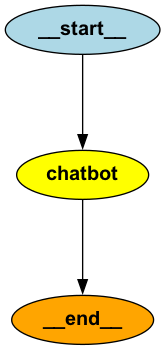

In [14]:
# uv add pygraphviz or pip install pygraphviz
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

### Run The Graph

In [15]:
nest_asyncio.apply()


async def stream_graph_updates(user_input: str) -> None:
    """Process user input through a graph and stream assistant responses.

    This function takes a user input string and streams it through an async graph,
    printing the assistant's messages as they are generated.

    Parameters
    ----------
    user_input : str
        The input text from the user to process

    Returns
    -------
    None
        This function prints output but does not return any value
    """
    async for event in graph.astream(
        {"messages": [{"role": "user", "content": user_input}]}
    ):
        print(f"Assistant: {event['chatbot']['messages']}")

In [16]:
# Test user input
await stream_graph_updates(user_input="Tell me a joke about Cercei Lannister.")

Assistant: Why did Cersei Lannister bring a ladder to the wedding? Because she wanted to reach the top of the heap (heap being a play on 'heaps' of money and the word 'heap' in the phrase 'reach the top of the heap').


In [17]:
while True:
    try:
        user_input: str = input("User: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break
        await stream_graph_updates(user_input)

    except Exception:
        # Fallback
        user_input = "Tell me a joke about Cercei Lannister."
        print(f"User: {user_input}")
        await stream_graph_updates(user_input)
        break

Assistant: Journey Home is a television show that airs on EWTN (Eternal Word Television Network), a Catholic television network. The show is a continuation of the Journey Man series, which was a popular show on EWTN in the early 2000s. Journey Home is a series of short, inspirational videos that feature real people sharing their personal stories of faith, redemption, and spiritual growth. The show is produced by EWTN and is available on their website and through their streaming service. The show has been praised for its authentic and heartfelt storytelling, and it has been a source of inspiration for many viewers. However, I should note that the show is not as widely known as some other shows on EWTN, and it may not be as popular as it was in the early 2ity. The show is available for streaming on EWTN's website and through their mobile app.
Assistant: bye
Goodbye!


## Tool Use

In [21]:
from langchain_core.tools import tool
from tavily import TavilyClient


@tool("tavily_search")
def tavily_search(query: str) -> dict:
    """
    Search for information using the Tavily API.

    Parameters
    ----------
    query : str
        The search query string.

    Returns
    -------
    dict
        The search results from Tavily.
    """
    tavily_client = TavilyClient(api_key=settings.TAVILY_API_KEY.get_secret_value())
    return tavily_client.search(query)

In [ ]:
response = tavily_search("Who is Leo Messi?")
console.log(response)

[19:36:29] {                                                                                        ]8;id=35981;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_80474/1587889692.py\1587889692.py]8;;\:]8;id=697938;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_80474/1587889692.py#2\2]8;;\
               'query': 'Who is Leo Messi?',                                                                       
               'follow_up_questions': None,                                                                        
               'answer': None,                                                                                     
               'images': [],                                                                                       
               'results': [                                                                                        
                   {                                                                                               
                       'title': 'Lionel Messi - Wikipedia',                                                        
                       'url': 'https://en.wikipedia.org/wiki/Lionel_Messi',                                        
                       'content': "Widely regarded as one of the greatest players of all time,                     
           Messi set numerous records for individual accolades won throughout his professional                     
           footballing career such as eight Ballon d'Or awards and eight times being named the                     
           world's best player by FIFA.[note 2] He is the most decorated player in the history of                  
           professional football having won 45 team trophies,[note 3] including twelve Big Five                    
           league titles, four UEFA Champions Leagues, two Copa Américas, and one FIFA World Cup.                  
           Messi holds the records for most European Golden Shoes (6), most goals in a calendar                    
           year (91), most goals for a single club (672, with Barcelona), most goals (474),                        
           hat-tricks (36) and assists (192) in La Liga, most assists (18) and goal contributions                  
           (32) in the Copa América, most goal contributions (21) in the World Cup, most                           
           international appearances (191) and international goals (112) by a South American male,                 
           and the second-most in the latter category outright.",                                                  
                       'score': 0.80698997,                                                                        
                       'raw_content': None                                                                         
                   },                                                                                              
                   {                                                                                               
                       'title': 'Lionel Messi: Biography, Soccer Player, Inter Miami CF, Athlete',                 
                       'url': 'https://www.biography.com/athletes/lionel-messi',                                   
                       'content': 'Lionel Messi, a forward for Inter Miami CF, is one of the                       
           world’s greatest soccer players and helped the Argentina national team win its third                    
           FIFA World Cup in 2022. Messi, now playing for Inter Miami CF of the MLS, helped his                    
           home country win soccer’s biggest event for the first time since 1986, scoring two goals                
           in the final and leading Argentina to a 4-2 win over Kylian Mbappé and France on                        
           penalties. Lionel Messi is an Argentinian soccer player who 